main script for the vibrating string problem.

In [1]:
from kernel import gram_Matrix
from optimization_lib import optimization_restarts_parallel_TNC, optimization_restarts_parallel_CG, gaussian_optimization, optimization_restarts_parallel_LBFGS
from create_data import get_data_set,create_validation_set
from plot_lib import plot_prediction, plot_variance, plot_difference_analytical, plot_both_pred_analy
from posterior import posterior_distribution_f, posterior_distribution_u
from L2error import MSE_error
import numpy as np
from skopt.space import Real

To run this notebook, you need the following packages:
- numpy, matplotlib, scipy, jax, jaxlib, tqdm, sklearn
This notebook does not show all the single functions, but just calls them. If you want to see the functions, you can open the .py files in the same folder.

First we compute our data with wolfram(see: PDE_solution_wolfram.nb) and save it in a file. Then we load the data and plot it. The training data is sampled with a sobol sequence(qmc method).



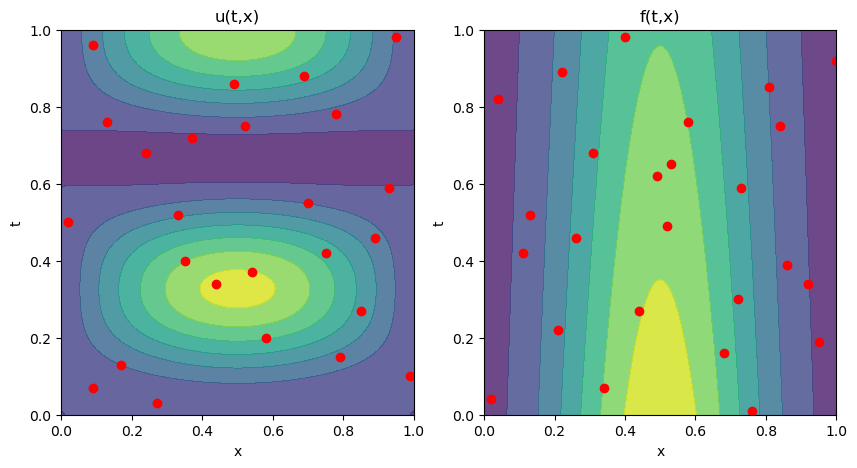

In [2]:
%%capture --no-display 
#just caprutes the warnings for the notebook. comment out if you want to see the warnings
n_training_points = 25
noise = [1e-5,1e-5]
filename = 'gaussian_f_c3.csv'
x_u, x_f, t_u, t_f, u_train, f_train, raw_data = get_data_set(n_training_points, noise,filename)
targets_train = np.vstack((u_train, f_train))

The next step is to create the parameters for the optimization. I implemented 4 different optimization methods:
- L-BFGS-B
- Conjugate Gradient
- Baysian Optimization
- TNC (Truncated Newton)    

The methods require different parameters, which are explained in the following. The parameters are saved in a dictionary, which is then passed to the optimization function. For different data sets, different parameters are needed. The optimization is done with n restarts, which means that the optimization is done n times with different starting points. The best result is then taken. The runs are multithreaded. You can choose how many threads are used with the n_job variable.


In [7]:
def get_initial_values():
    """returns the initial values for the hyperparameters
    for the length scales we initialize them randomly as log(l) ~ U(-2.5,1)
    """
    rng = np.random.default_rng()
    theta_initial = np.zeros((4))
    theta_initial[0] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[1] = rng.uniform(0, 2, 1)
    theta_initial[2] = np.exp(rng.uniform(-1.3, 0.3, 1))
    theta_initial[3] = rng.uniform(1, 4, 1)
    return theta_initial

dictionary_BFGS_CG_TNC = {'theta_initial': get_initial_values,   #needed for all optimization methods
                          'bounds': ((1e-2, None), (1e-2, None), (1e-1, None),(1e-2, None)), #needed for TNC and L-BFGS-B
                          'gtol': 1e-6}

#parameters for the Baysian Optimization
ranges = [Real(1e-1, 3, name='l_x', prior="log-uniform"),
          Real(1e-2, 3, name='sigma_f_sq', prior="uniform"),
          Real(1e-1, 3, name='l_t', prior="log-uniform"),
          Real(1e-1, 4, name='alpha', prior="uniform")]
bays_opt_dictionary = {'dimensions': ranges,
                       'n_calls': 80,
                       'n_initial_points': 20,
                       'verbose': False,
                       'noise': 1e-4,
                       'n_restarts_optimizer': 6,
                       "n_jobs": -1                       
                        }
n_restarts = 200
n_threads = -1

In [8]:
#BFGS_result = optimization_restarts_parallel_LBFGS(gram_Matrix,n_restarts, n_threads, dictionary_BFGS_CG_TNC, X=x_u, Y=x_f, T=t_u, S=t_f, targets=targets_train, noise=noise)
CJ_result = optimization_restarts_parallel_CG(gram_Matrix,n_restarts, -1, dictionary_BFGS_CG_TNC, X=x_u, Y=x_f, T=t_u, S=t_f, targets=targets_train, noise=noise)

#bo_results = gaussian_optimization(bays_opt_dictionary,gram_Matrix,restarts = 10, X=x_u, Y=x_f, T=t_u, S=t_f, targets=targets_train, noise=noise)
TNC = optimization_restarts_parallel_TNC(gram_Matrix, n_restarts, -1, dictionary_BFGS_CG_TNC, X=x_u, Y=x_f, T=t_u, S=t_f, targets=targets_train, noise=noise)













100%|██████████| 200/200 [00:23<00:00,  8.51it/s]


------CG------
     fun: 11.880599975585938
     jac: array([0., 0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 15
     nit: 1
    njev: 3
  status: 0
 success: True
       x: array([0.72176651, 1.95601351, 0.32509022, 3.07057189])


KeyboardInterrupt: 

In [ ]:
best_result = min([CJ_result, TNC], key=lambda x: x.fun)
print('-------------------------------------best result------------------------------------------')
print("function value:",best_result.fun,"|theta(l_x, sigma_f, l_t, c):",best_result.x)


-------------------------------------best result------------------------------------------
function value: 1.0480365753173828 |theta(l_x, sigma_f, l_t, c): [0.56786308 0.07442531 0.26437947 2.99079524]


Now that we have found the optimal $\theta$ we can make predictions.

c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\vibrating_string\plot_lib.py:36: RuntimeWarning: invalid value encountered in sqrt
  cont_1 = ax[1].contourf(x_star.reshape(var_f.shape), t_star.reshape(var_f.shape), np.sqrt(var_f), cmap="viridis", alpha=0.8)


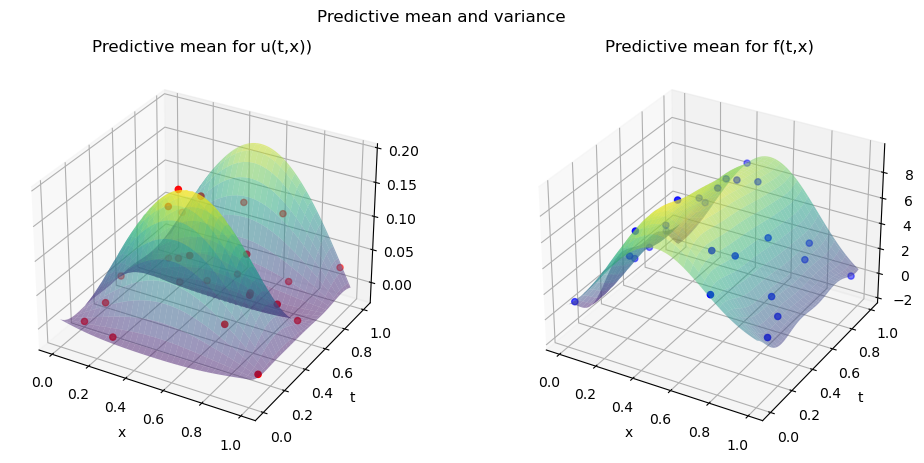

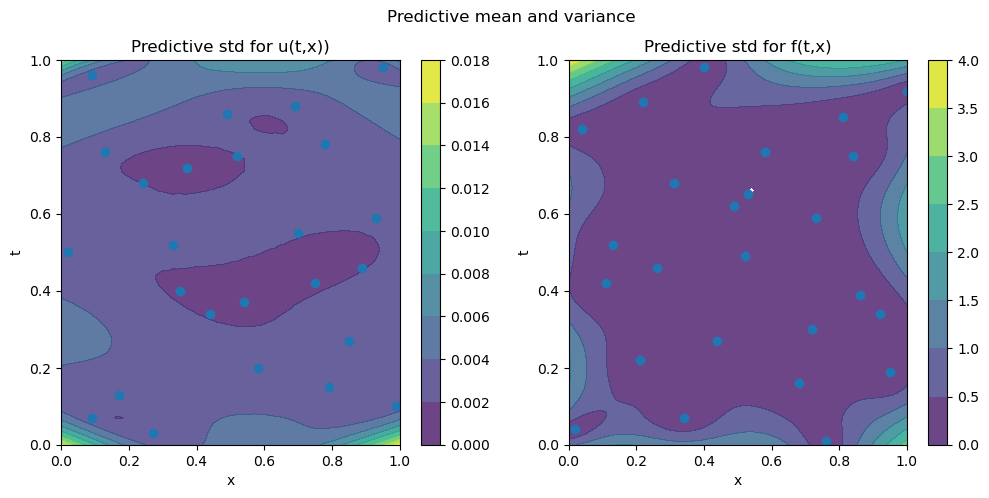

In [ ]:
n_test_points = 101
t_test, x_test = np.linspace(0,int(np.max(raw_data[1])),n_test_points).reshape(-1,1), np.linspace(0,1,n_test_points).reshape(-1,1)
t_star, x_star = np.meshgrid(t_test, x_test)
t_star, x_star = t_star.reshape(-1,1), x_star.reshape(-1,1)

theta = best_result.x
#theta = [0.72267089, 0.046254  , 0.50923536, 0.98401197]

mean_u, var_u = posterior_distribution_u(x_u, x_f, t_u, t_f, x_star, t_star, targets_train, noise, theta, gram_Matrix)
mean_f, var_f = posterior_distribution_f(x_u, x_f, t_u, t_f, x_star, t_star, targets_train, noise, theta, gram_Matrix)
mean_u = mean_u.reshape(n_test_points,n_test_points)
mean_f = mean_f.reshape(n_test_points,n_test_points)
var_u = var_u.reshape(n_test_points,n_test_points)
var_f = var_f.reshape(n_test_points,n_test_points)
#now we can plot the results
plot_prediction(x_u, t_u, x_f, t_f, u_train, f_train, x_star, t_star, mean_u, mean_f, title='Predictive mean and variance', save_path='plots/predictive_mean.png')
plot_variance(x_u, t_u, x_f, t_f, u_train, f_train, x_star, t_star, var_u, var_f, title='Predictive mean and variance', save_path='plots/predictive_variance.png')

We can further compare the results with the numerical solution.

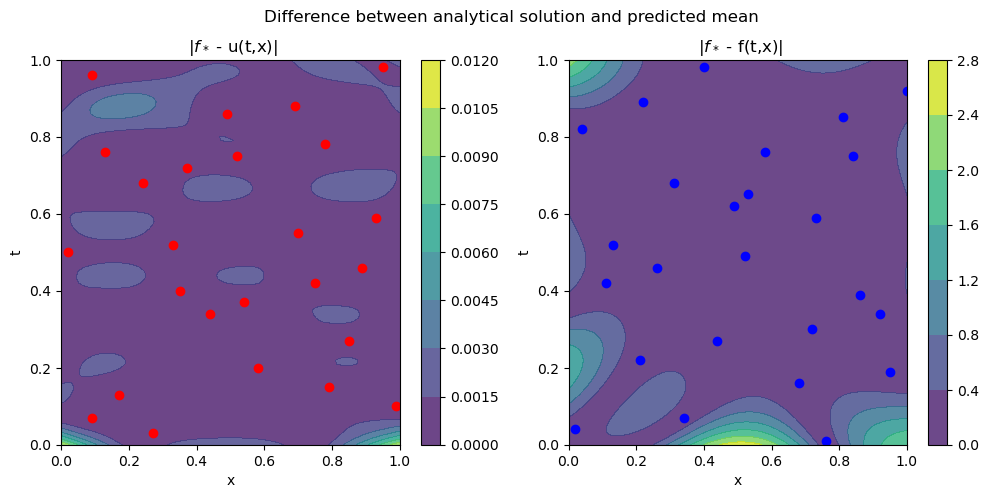

In [ ]:
x_star = raw_data[0].reshape(-1,1)
t_star = raw_data[1].reshape(-1,1)
u_grid = raw_data[2]
f_grid = raw_data[3]

mean_u_wolfram_grid, var = posterior_distribution_u(x_u, x_f, t_u, t_f, x_star, t_star, targets_train,noise, theta, gram_Matrix)
mean_f_wolfram_grid, var = posterior_distribution_f(x_u, x_f, t_u, t_f, x_star, t_star, targets_train,noise, theta, gram_Matrix)
mean_u_wolfram_grid = mean_u_wolfram_grid.reshape(u_grid.shape)
mean_f_wolfram_grid = mean_f_wolfram_grid.reshape(u_grid.shape)

plot_difference_analytical(x_u, t_u, x_f, t_f, u_train, f_train, x_star, t_star, mean_u_wolfram_grid, mean_f_wolfram_grid, u_grid, f_grid, title='Difference between analytical solution and predicted mean', save_path='plots/difference.png')

At last we look at the MSE error of the found parameters.

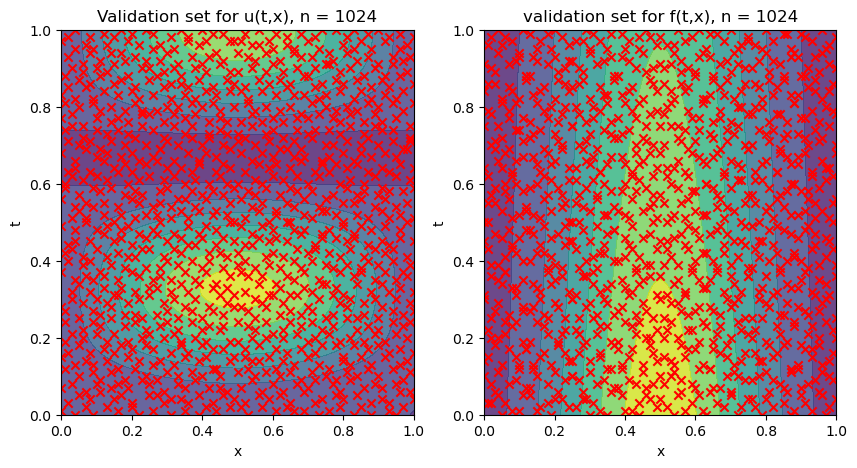

 MSE for u: 0.0008992088 MSE for f 0.21788661


c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\vibrating_string\create_data.py:34: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = engine.random(n_training_points)
c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\vibrating_string\create_data.py:44: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = engine.random(n_training_points)
c:\Users\Razer\OneDrive - Technische Universität Graz\Dokumente\Uni\6.Semester\BAC\Code_bac\vibrating_string\create_data.py:60: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  ax[1].contourf(x_mesh,t_mesh,f_grid,cmap='viridis',edgecolor='none',alpha=0.8)


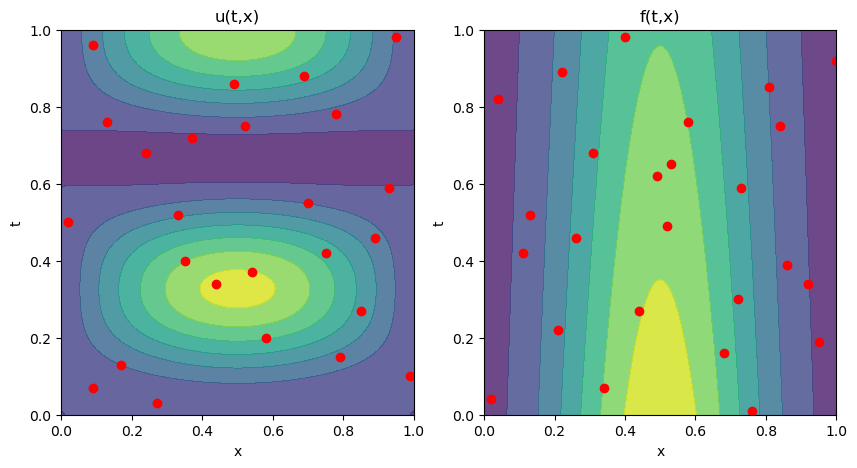

In [ ]:
validation_points_base_2 = 10 # 2**10 = 1024
validation_set = create_validation_set(10, noise, filename)
MSE_u, MSE_f = MSE_error(validation_set,n_training_points, noise, filename, theta)
print(" MSE for u:",MSE_u,"MSE for f" ,MSE_f)